In [1]:
%load_ext autoreload

%autoreload 2

%matplotlib inline

import os
import sys
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import pacmap
import umap
import trimap

from scipy.stats import chisquare, chi2_contingency, pearsonr
from scipy.stats import kendalltau,spearmanr, weightedtau, theilslopes, wilcoxon, ttest_rel
from scipy.spatial import distance
import dcor

from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap, MDS, SpectralEmbedding
from sklearn.manifold import LocallyLinearEmbedding as LLE, TSNE, smacof, trustworthiness


from sklearn.metrics import rand_score, adjusted_mutual_info_score, adjusted_rand_score
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.cluster import KMeans

from utils import poincarre_dist
import quality_metrics
import numpy.linalg as la
import torch 

from numba import njit

import faiss


Embeddings to test:
* PCA
* LMDS: 
* LMVU:
* SMACOF:
* GPLVM: 
* RankVisu:
* DD-HDS: 
* NeuroScale: 
* UMAP, [gitub](https://umap-learn.readthedocs.io/en/latest/index.html), [paper](https://arxiv.org/abs/1802.03426)
* DenseMap, part of UMAP library, [paper](https://www.biorxiv.org/content/10.1101/2020.05.12.077776v1)
* IVIS, [github](https://github.com/beringresearch/ivis), [paper](https://www.nature.com/articles/s41598-019-45301-0)
* PHATE, [github](https://phate.readthedocs.io/en/stable/), [paper](https://www.nature.com/articles/s41587-019-0336-3)
* PACMAP, [github](https://github.com/YingfanWang/PaCMAP), [paper](https://jmlr.org/papers/v22/20-1061.html)
* TriMap, [github](https://github.com/eamid/trimap), [paper](https://arxiv.org/abs/1910.00204)
* HOPE, [github](https://github.com/palash1992/GEM), [paper](https://dl.acm.org/doi/abs/10.1145/2939672.2939751)
* opt-SNE, [github](https://github.com/omiq-ai/Multicore-opt-SNE), [paper](https://www.biorxiv.org/content/10.1101/451690v3)
* FactorizedEmbeddings,[github](https://github.com/TrofimovAssya/FactorizedEmbeddings), [paper](https://academic.oup.com/bioinformatics/article/36/Supplement_1/i417/5870511)

Table with the embeddings, the quality metrics for different numbers of dimensions.

In [49]:
X = np.random.normal(0,10,(500000,100))


In [50]:

index = faiss.IndexFlatL2(X.shape[1],)

index.add(X.astype(np.float32))

k = 30                          # we want n similar vectors
D, I = index.search(X.astype(np.float32), k)     # actual search


In [61]:
import trimap

pca_ = trimap.TRIMAP(n_dims=2)
X_emb = pca_.fit_transform(X)

TRIMAP(n_inliers=10, n_outliers=5, n_random=5, distance=euclidean, lr=1000.0, n_iters=400, weight_adj=500.0, apply_pca=True, opt_method=dbd, verbose=True, return_seq=False)
running TriMap on 500000 points with dimension 100
pre-processing
found nearest neighbors
sampled triplets
running TriMap with dbd
Iteration:  100, Loss: 6943094.500, Violated triplets: 25.2476
Iteration:  200, Loss: 6761224.000, Violated triplets: 24.5863
Iteration:  300, Loss: 6690297.000, Violated triplets: 24.3284
Iteration:  400, Loss: 6662102.500, Violated triplets: 24.2258
Elapsed time: 0:13:23.108940


In [70]:

index_emb = faiss.IndexFlatL2(X_emb.shape[1],)

index_emb.add(X_emb.astype(np.float32))

k = 30                          # we want n similar vectors
D_emb, I_emb = index_emb.search(X_emb.astype(np.float32), k)     # actual search


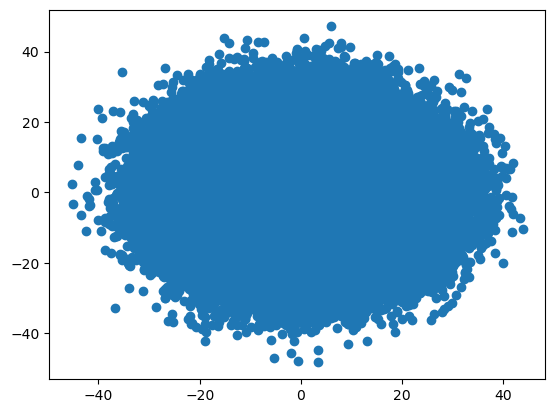

In [71]:
import matplotlib.pyplot as plt
plt.scatter(X[:,0],X[:,50])

In [72]:
from sklearn.metrics import jaccard_score
from scipy.spatial.distance import hamming, jaccard


In [73]:
D.shape

(500000, 30)

In [74]:
D_emb.shape

(500000, 30)

In [75]:
hamming_ds = np.zeros(I.shape[0])
for i in range(hamming_ds.shape[0]):
    hamming_ds[i] = hamming(I[i,:],I_emb[i,:])
jaccard_ds = np.zeros(I.shape[0])
for i in range(jaccard_ds.shape[0]):
    jaccard_ds[i] = jaccard(I[i,:],I_emb[i,:])

In [77]:
jaccard_ds

array([1.        , 0.96666667, 0.96666667, ..., 0.96666667, 0.96666667,
       0.96666667])

#### celldyn data

In [2]:
celldyn_full = pd.read_feather("L:\laupodteam\AIOS\Bram\data\CellDyn\celldyn_fullcase_cleaned_transformed.feather")
meas_columns = [c for c in celldyn_full.columns if 'c_b' in c]
mode_columns = [c for c in celldyn_full.columns if 'c_m' in c]
alrt_columns = [c for c in celldyn_full.columns if 'alrt' in c.lower()]
c_s_columns = [c for c in celldyn_full.columns if 'c_s_' in c.lower()]

In [18]:
sample_df = celldyn_full.sample(200000)
sample_df = sample_df
reduce_dim = 10


embedder_full = umap.UMAP(n_components=reduce_dim,metric = poincarre_dist)
le_pipe = Pipeline([('scaler', StandardScaler()),
                    ('embedder', embedder_full)])

le_pipe.fit(sample_df[meas_columns]) # final_columns


c:\Users\hjoosse3\.conda\envs\embcelldyn\lib\site-packages\umap\umap_.py:1772: UserWarning: custom distance metric does not return gradient; inverse_transform will be unavailable. To enable using inverse_transform method, define a distance function that returns a tuple of (distance [float], gradient [np.array])
  warn(


Pipeline(steps=[('scaler', StandardScaler()),
                ('embedder',
                 UMAP(metric=CPUDispatcher(<function poincarre_dist at 0x0000020B9B3D1670>), n_components=10, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True}))])

In [19]:
from quality_metrics import CDEmbeddingPerformance

In [25]:
emb_perf = CDEmbeddingPerformance(
    sample_df[meas_columns].values.astype(np.float32).copy(order = 'C'),
    le_pipe.named_steps['embedder'].embedding_,
    metric = poincarre_dist
    )

In [26]:
overlap, dist_cor, trust = emb_perf.score()

In [ ]:
dist_cor

0.21581008271565633

In [ ]:
trust

0.6746090725806451